# Auto correlation (ACF, PACF), Auto Regressive Models

### Revisão
- Detecção de Tendência e Sazonalidade
    - Exploração Visual
    - Decomposição de Séries Temporais (HP-Filter e STL)
- Estacionariedade (Conceito e testes)
- Alisamento Exponencial (Simples, Duplo e Triplo)
- Introdução ao operador lag e auto correlação
### Hoje
- Revisão 
- Transformações para atingir estacionariedade
- Operador Lag
- ACF e PACF
- Modelos AR
- Modelos ARI

### Preparação


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import co2, get_rdataset
plt.rcParams["figure.figsize"] = [12, 5]
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True).resample('MS').mean()
co2_df = co2.load_pandas().data
co2_s = co2_df.ffill().resample('MS').mean()
air_passengers = get_rdataset("AirPassengers")
airp_s = air_passengers.data
airp_s.index = pd.date_range('1949', '1960-12', freq='MS')
airp_s.drop(columns=['time'], inplace=True)
df = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/netflix_titles.csv')
df['date_added']=pd.to_datetime(df['date_added'], format='%B %d, %Y', errors = 'coerce')
df.index = df['date_added']
lancamentos = df.set_index('date_added').resample('MS').size()
netflix = lancamentos[lancamentos.index.year>2015]

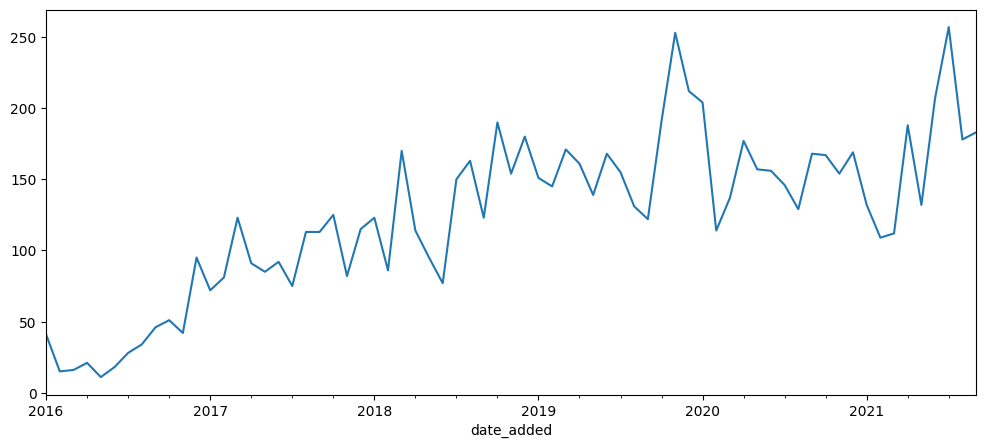

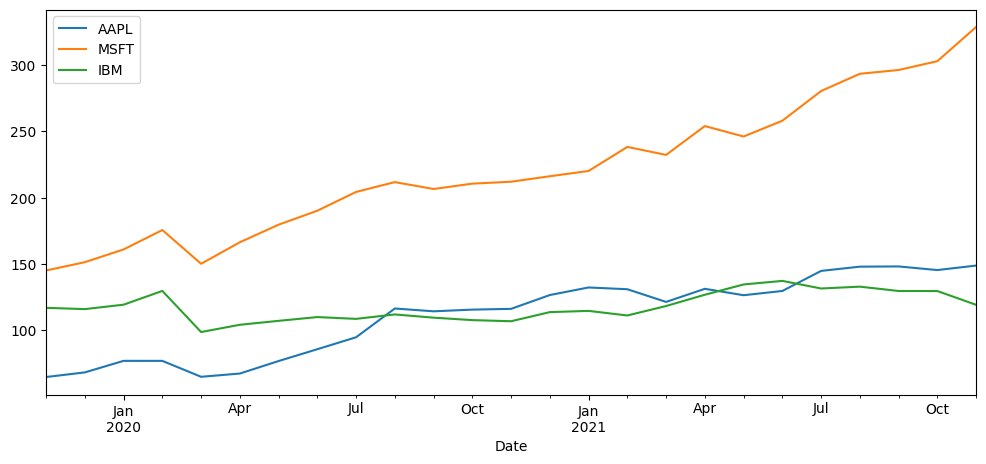

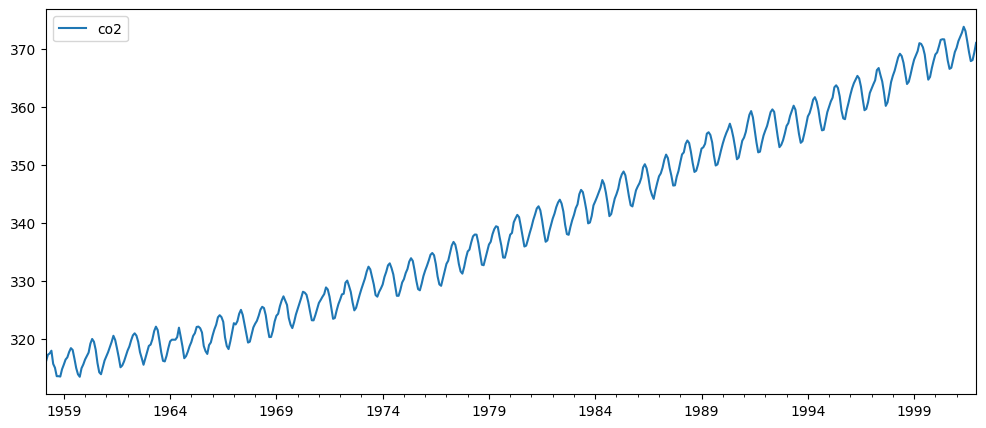

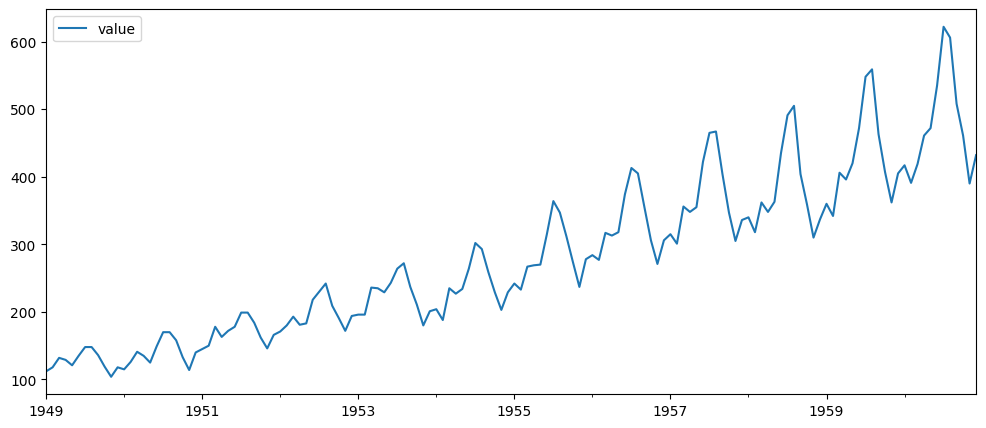

In [68]:
for s in [netflix,closing_price, co2_s, airp_s]:
    s.plot()

<Axes: xlabel='Date'>

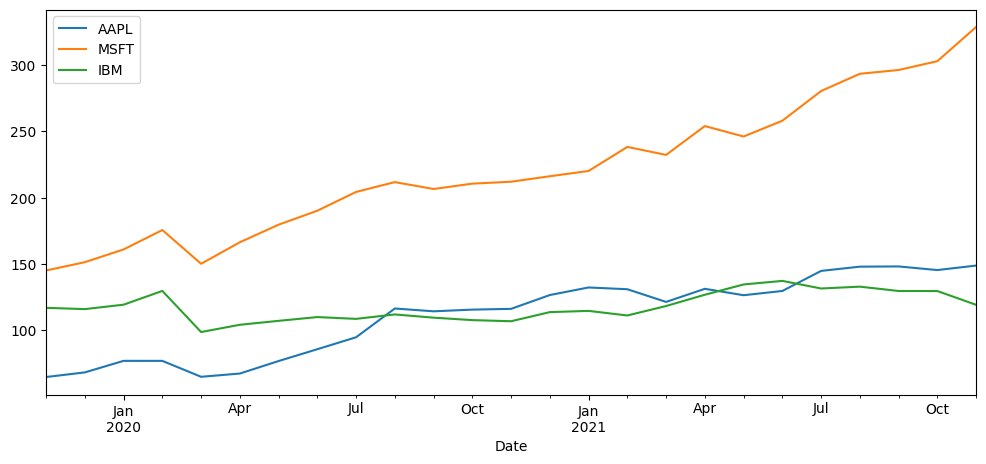

In [26]:
closing_price.plot()

In [54]:
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill().resample('MS').mean()
co2_df


,co2
1958-03-01,316.100
1958-04-01,317.200
1958-05-01,317.420
1958-06-01,317.900
1958-07-01,315.625
...,...
2001-08-01,369.425
2001-09-01,367.880
2001-10-01,368.050
2001-11-01,369.375


<Axes: >

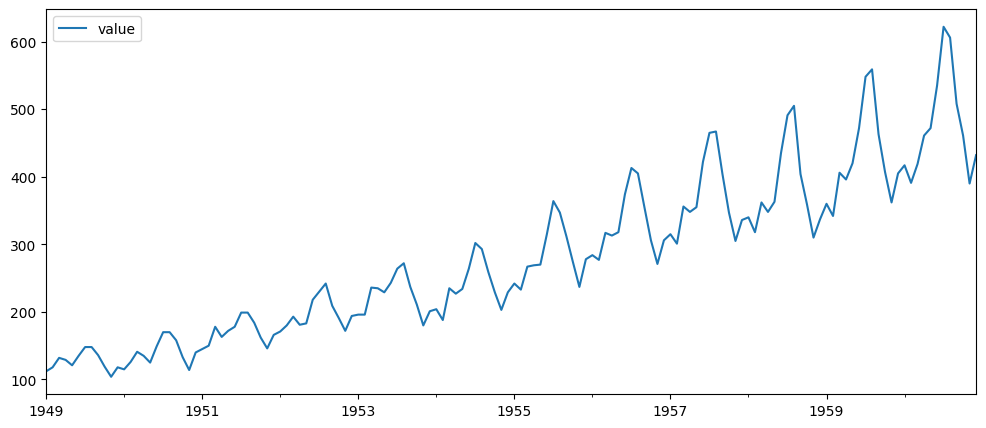

In [ ]:

airp_df.plot()

In [43]:
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_2467/805844026.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  airp_df.index = pd.date_range('1949', '1961', freq='M')


In [44]:
airp_df

,value
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390


In [5]:
co2_df

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


## Transformações para atingir estacionariedade
